# 1.0 데이터 불러오기

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# 신문고
dfsin=pd.read_csv('./test/sinmungo_total.csv')[['text','agency','date','keyword']]
dfsin['year'] = pd.to_datetime(dfsin['date']).dt.year
print(dfsin.isnull().sum())
dfsin = dfsin.dropna(axis=0)
# dfsin

# # 네이버 다음
# # ['title', 'text', 'site', 'source', 'keyword', 'year']
# dfnd=pd.read_csv('./test/naver_daum_total.csv')
# print(dfnd.isnull().sum())
# dfnd = dfnd.dropna(axis=0)
# dfnd.isnull().sum()
# # dfnd

text       0
agency     0
date       0
keyword    0
year       0
dtype: int64


In [ ]:
# 텍스트 열을 기준으로 완전히 동일한 중복글의경우 제일 처음 등장한녀석만 살리고, 중복제거 (그래도 어느정도 중복내용존재)
# dfsin=dfsin.drop_duplicates(['text'])

# 1.1 데이터 속 인식 불가단어 미리보기
## Kiwi 이용해서 인식불가단어 검출 
### (ckonlpy에서 사용자단어 처리할때 사용할 것)

In [4]:
dfsin['text'].apply(lambda x : x.upper().replace('[^ ㄱ-ㅣ가-힣|0-9|a-zA-Z]', " ")
                   ).to_csv('./test/kiwi_Word_Extract.txt', index=False, header=None, encoding='utf-8' )

In [5]:
from kiwipiepy import Kiwi, Option
kiwi = Kiwi(num_workers=0, model_path='./', options=Option.LOAD_DEFAULT_DICTIONARY | Option.INTEGRATE_ALLOMORPH)

class ReaderExam:
    def __init__(self, filePath):
        self.file = open(filePath, encoding='utf-8')
    
    def read(self, id):
        if id == 0: self.file.seek(0)
        return self.file.readline()


In [6]:
reader = ReaderExam('./test/kiwi_Word_Extract.txt')
kiwiextracted=kiwi.extract_words(reader.read, min_cnt=1000,max_word_len=10, min_score=1.5)
kiwiextracted

[('버스', 3.5852818489074707, 11676, -3.1944169998168945),
 ('GTX-D', 3.5418777465820312, 12618, -1.0342339277267456),
 ('착공하여', 3.1028079986572266, 6629, -4.155839920043945),
 ('건설계획)은', 2.943880081176758, 5698, -5.9631524085998535),
 ('검단신도시', 2.832468032836914, 20297, -3.2916386127471924),
 ('성공과', 2.7487964630126953, 5698, -4.966219902038574),
 ('노선', 2.719985008239746, 39017, -2.87424898147583),
 ('갈림길입니다.', 2.6970250606536865, 5688, -8.067988395690918),
 ('개통시켜', 2.665499210357666, 6637, -4.154057502746582),
 ('관련', 2.6429460048675537, 4374, -4.0925798416137695),
 ('2020년', 2.4584577083587646, 5009, -4.0022430419921875),
 ('직선화', 2.4274048805236816, 6656, -4.154990196228027),
 ('강력요구합니다', 2.399015426635742, 4101, -6.303318023681641),
 ('공공주택지구', 2.37469744682312, 5722, -4.155839920043945),
 ('도시철도망구축계획', 2.28224515914917, 5233, -4.150746822357178),
 ('호평/평내동', 2.2451815605163574, 1560, -4.155839920043945),
 ('광역급행버스', 2.235891103744507, 4473, -3.894906520843506),
 ('교산신도시의', 2.1270

# 2.0 토큰화, 지역성

## 2.1 토큰화

### 2.1.1 사용자사전 추가

In [3]:
def mkLocationList():
    newNouns=set()
    with open('./참고파일/지역명/철도역명.txt', encoding='utf-8') as f:
        for line in f:
            word=line.replace('\t','').replace('Noun','').strip('\n')
            if len(word)<2:continue
            newNouns.add(word)
    with open('./참고파일/지역명/법정동리명.txt', encoding='utf-8') as f:
        for line in f:
            word=line.replace('\t','').replace('Noun','').strip('\n')
            if len(word)<3 : continue
            newNouns.add(word)
    with open('./참고파일/지역명/시군구명.txt', encoding='utf-8') as f:    
        for line in f:
            word=line.replace('\t','').replace('Noun','').strip('\n')
            newNouns.add(word)

    return list(newNouns)

locations = mkLocationList()

def locationToken(tokens):
    for token in tokens:
        if token in locations:
            return 1
    return None
# locations = mkLocationList()
# locations

def mkNewWordList():
    newWordList=[]
    with open('./ckonlpy/사용자단어.txt' ,encoding='utf-8') as f:
        for line in f:
            newWordList.append(line)
    return newWordList

In [63]:
from konlpy.tag import Okt;okt=Okt()
from ckonlpy.utils import load_wordset,load_ngram,load_replace_wordpair
from ckonlpy.tag import Twitter
from ckonlpy.tag import Postprocessor
twitter=Twitter()

사용자단어=mkNewWordList()
지역명=mkLocationList()
twitter.add_dictionary(사용자단어, 'Noun')
twitter.add_dictionary(지역명, 'Noun')
# twitter.add_dictionary(['교통비전'], 'Noun')
 
# ngrams=[(('동탄','신도시'),'Noun'),(('무정','차'),'Noun')]
replace = load_replace_wordpair('./ckonlpy/replace.txt')
ngrams = load_ngram('./ckonlpy/ngram.txt')
stopwords = load_wordset('./ckonlpy/stopwords.txt')
passwords = load_wordset('./ckonlpy/passwords.txt')

postprocessor = Postprocessor(
    base_tagger = twitter, # base tagger
    stopwords = stopwords, # 해당 단어 거르기
#     passwords = passwords, # 해당 단어만 선택
    passtags = {'Noun','Alpha','Number' ,'Adjective' },#, 'Verb'}, # 해당 품사만 선택
    replace = replace, # 해당 단어 set 치환
    ngrams = ngrams    # 해당 복합 단어 set을 한 단어로 결합
)

def mkToken(sent):#ngrams에서 ' - ' 로 단어가 붙어나오는걸 띄어쓰기삭제
    tmp=re.sub(pattern='[^ ㄱ-ㅣ가-힣|0-9|a-zA-Z]+', repl=' ', string=sent).strip()
    return [s.replace(' - ','') for s,v in postprocessor.pos(tmp.upper()) if len(s)>1]

# sent='버스노선및 신호등 관련 민원'
print(mkToken(sent),'    지역성 : ',locationToken(mkToken(sent)))

C:\Users\hj\anaconda3\envs\textMining_ipython upgrade\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['검단신도시', 'GTX', '노선', '인천', '입장', '변함', '없는것', '가요']     지역성 :  1


In [74]:
# import kss
# from hanspell import spell_checker
import re
sent='형준입니다'
sent = re.sub(pattern='[^ ㄱ-ㅣ가-힣|0-9|a-zA-Z]+', repl=' ', string=sent).strip()
# print(spell_checker.check(sent))
# print(okt.pos(sent,stem=True))
print(kss.split_sentences(sent))
print(mkToken(sent))
# print(mkToken(sent),'    지역성 : ',locationToken(mkToken(sent)))

['형준입니다']
['형준', '입니다']


In [67]:
# 텍스트를 토큰으로 분류
# dftest=dfsin.query('year=="2019"').reset_index()
dfsin['token']=dfsin['text'].apply(lambda x : mkToken(x))
dfsin[['text','token']]

,text,token
0,2번 마을버스 노선,"[마을버스, 노선]"
1,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
2,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
3,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
4,건설표준품셈 노선측량 중 노선선정과 노선선점 정의,"[건설, 표준, 노선, 측량, 노선, 선정, 노선, 선점, 정의]"
...,...,...
62020,대전역 서광장 택시전용차로,"[대전역, 서광, 택시전용차로]"
62021,1가구 4주택시 취득세 4% 문의드립니다.,"[가구, 주택, 취득세, 문의]"
62022,"울산 남구 롯데시티호텔,신라스테이 앞 택시 승강장 만들어주셔요","[울산, 남구, 롯데, 시티, 호텔, 신라, 스테이, 택시승강장]"
62023,택시에 휴대폰을 두고 내렸는데 과도한 보상금을 요구 (광주),"[택시, 휴대폰, 과도, 보상금, 요구, 광주]"


In [6]:
# text 를 기준으로 간단 중복제거했을때 -> 6098개로, 데이터가 10%만 남게됨
dfsin.drop_duplicates('text')

,text,agency,date,keyword,year,token
0,2번 마을버스 노선,경기도 하남시,2019-12-31,노선,2019,"[마을버스, 노선]"
1,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
4,건설표준품셈 노선측량 중 노선선정과 노선선점 정의,국토교통부,2019-12-26,노선,2019,"[건설, 표준, 노선, 측량, 노선, 선정, 노선, 선점, 정의]"
6,검단신도시 5호선 연장 노선확정 촉구,인천광역시,2019-12-19,노선,2019,"[검단신도시, 5호선, 연장, 노선확정, 촉구]"
7,3차 국가철도망 계획에 반영된 지하철 3호선 운정신도시 직선화 노선으로 신속 착공 ...,국토교통부,2019-12-19,노선,2019,"[국가, 철도망, 계획, 반영, 지하철, 3호선, 운정신도시, 직선화, 노선, 신속..."
...,...,...,...,...,...,...
62020,대전역 서광장 택시전용차로,대전광역시,2020-02-04,택시,2020,"[대전역, 서광, 택시전용차로]"
62021,1가구 4주택시 취득세 4% 문의드립니다.,전라남도,2020-02-04,택시,2020,"[가구, 주택, 취득세, 4%, 문의]"
62022,"울산 남구 롯데시티호텔,신라스테이 앞 택시 승강장 만들어주셔요",울산광역시,2020-01-30,택시,2020,"[울산, 남구, 롯데, 시티, 호텔, 신라, 스테이, 택시승강장]"
62023,택시에 휴대폰을 두고 내렸는데 과도한 보상금을 요구 (광주),경찰청,2020-01-17,택시,2020,"[택시, 휴대폰, 과도, 보상금, 요구, 광주]"


## 2.2 토큰의 경기도 여부

### 2.2.1 (신문고) 데이터 Agency로, 지역성

In [ ]:
# 관련기관으로 함께 작성해놓은것에서 지역성 text가 얼마나 연관있는지 테스트 -> 거의 ... 효과없음
def agencyLot(sent):
    locat=['시','군','구','도']
    if sent[-1] in locat:
        return False
    else:
        return True
# for i in dfsin[dfsin['agency'].apply(lambda x : agencyLot(x))]['text']:
#     print(i)

### 2.2.2 경기도 토큰을 이용하여 경기도에 관한 내용들만 뽑기

In [29]:
with open('./ckonlpy/경기_시군구키워드.txt', encoding='utf-8') as f:
    tmpset=set()
    for line in f:
        word=line.replace('\t','').replace('Noun','').strip('\n')
        if len(word)<3:continue
        words=word.split('.')
        if len(words)==1:
            tmpset.add(words[0])
        else:
            for word in words:
                tmpset.add(word)
#         print(word)
gyeonggiToken=list(tmpset)
def isAgencyGyeonggi(agency):
    if '경기' in agency:
        return True
    else:
        return False
    
def isTokenGyeonggi(tokens):
    for token in tokens:
        if token in gyeonggiToken:
            return True
        else:
            return False

In [30]:
#####경기도 관련기관으로 선택한것 거르기!
dfgyeonggi = dfsin[dfsin['agency'].apply(lambda x: isAgencyGyeonggi(x))]
dfgyeonggi
# dfsin[ dfsin['token'].apply(lambda x: isTokenGyeonggi(x))]

,text,agency,date,keyword,year,token
0,2번 마을버스 노선,경기도 하남시,2019-12-31,노선,2019,"[마을버스, 노선]"
1,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
2,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
3,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
5,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-19,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
...,...,...,...,...,...,...
61998,한강교통 마을버스 운영하는 회사는 개인택시같은 회사인가요?,경기도 김포시,2020-03-19,택시,2020,"[한강, 교통, 마을버스, 영하, 회사, 개인, 택시, 회사]"
62001,중국에서 한국사람에게하는거보니 중국인을 택시에 태우고 싶지 않은데 승차 거부인가요?,경기도 이천시,2020-03-10,택시,2020,"[중국, 한국사, 중국인, 택시, 승차거부]"
62004,용인 택시 개선사항,경기도 용인시,2020-03-09,택시,2020,"[용인, 택시, 개선, 사항]"
62010,구리시 장애인콜택시 이용하려는데 의사진단서가 애 추가로 필요한가요?,경기도 구리시,2020-02-21,택시,2020,"[구리시, 장애인, 택시, 이용, 의사, 진단, 추가, 요한, 가요]"


In [31]:
# 기관경기도 아닌데 토큰에 경기도 내 지역 나타난것
dfNotGG = dfsin[dfsin['agency'].apply(lambda x: isAgencyGyeonggi(x)) == False]
dfNotGG = dfNotGG[dfNotGG['token'].apply(lambda x: isTokenGyeonggi(x))]

In [32]:
# 경기도를 관련기관으로 선택한것 + 그게아닌데 경기도 내 지역이 토큰검출된것
dftotalGG=pd.concat([dfgyeonggi,dfNotGG])#.to_csv('./경기도필터링.csv',sep=':',index=False, encoding='utf-8')
dftotalGG

,text,agency,date,keyword,year,token
0,2번 마을버스 노선,경기도 하남시,2019-12-31,노선,2019,"[마을버스, 노선]"
1,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
2,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
3,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-30,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
5,지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...,경기도 파주시,2019-12-19,노선,2019,"[지하철, 3호선, 대화, 덕이, 운정, 운정, 직선화, 노선, 착공, 개통]"
...,...,...,...,...,...,...
61646,부천시가 강남급행철도 유치를 위해 노력해 주세요.,인천광역시,2020-02-20,철도,2020,"[부천시, 강남, 급행철도, 유치, 위해, 노력]"
61649,부천시가 강남급행철도 유치를 위해 노력해 주세요.,인천광역시,2020-02-20,철도,2020,"[부천시, 강남, 급행철도, 유치, 위해, 노력]"
61652,부천시가 강남급행철도 유치를 위해 노력해 주세요.,인천광역시,2020-02-20,철도,2020,"[부천시, 강남, 급행철도, 유치, 위해, 노력]"
61826,검단신도시 7만 5천세대의 출퇴근과 교통체증을 해결하기위해 힘써주세요.,인천광역시,2020-03-30,출퇴근,2020,"[검단신도시, 7만, 천세, 대의, 출퇴근, 교통체증, 해결, 위해]"


## 2.3 토큰의 수단성

In [43]:
stationlist=[]
with open('./ckonlpy/역명.txt' , 'r',encoding='utf-8') as f:
    lines=f.readlines()
    for line in lines:
        try:
            stationlist.append(line.split()[0]+'역')
        except:continue
stationlist

['소요산역',
 '동두천역',
 '보산역',
 '동두천중앙역',
 '지행역',
 '덕정역',
 '덕계역',
 '양주역',
 '녹양역',
 '가능역',
 '의정부역',
 '회룡역',
 '망월사역',
 '도봉산역',
 '도봉역',
 '방학역',
 '창동역',
 '녹천역',
 '월계역',
 '광운대역',
 '석계역',
 '신이문역',
 '외대앞역',
 '회기역',
 '청량리역',
 '제기동역',
 '신설동역',
 '동대문역',
 '종로5가역',
 '종로3가역',
 '종각역',
 '시청역',
 '서울역역',
 '남영역',
 '용산역',
 '노량진역',
 '대방역',
 '신길역',
 '영등포역',
 '신도림역',
 '구로역',
 '구일역',
 '개봉역',
 '오류동역',
 '온수역',
 '역곡역',
 '소사역',
 '부천역',
 '중동역',
 '송내역',
 '부개역',
 '부평역',
 '백운역',
 '동암역',
 '간석역',
 '주안역',
 '도화역',
 '제물포역',
 '도원역',
 '동인천역',
 '인천역',
 '가산디지털단지역',
 '독산역',
 '금천구청역',
 '석수역',
 '관악역',
 '안양역',
 '명학역',
 '금정역',
 '군포역',
 '의왕역',
 '성균관대역',
 '화서역',
 '수원역',
 '세류역',
 '병점역',
 '세마역',
 '오산대역',
 '오산역',
 '진위역',
 '청량리역',
 '왕십리역',
 '응봉역',
 '옥수역',
 '한남역',
 '서빙고역',
 '이촌역',
 '동묘앞역',
 '시청역',
 '을지로입구역',
 '을지로3가역',
 '을지로4가역',
 '동대문역사문화공원역',
 '신당역',
 '상왕십리역',
 '왕십리역',
 '한양대역',
 '뚝섬역',
 '성수역',
 '건대입구역',
 '구의역',
 '강변역',
 '잠실나루역',
 '잠실역',
 '잠실새내역',
 '종합운동장역',
 '삼성역',
 '선릉역',
 '역삼역',
 '강남역',
 '교대역',
 '서초역',
 '방배역',
 '사당역',
 '낙성대역',
 '서울대입구역',

In [44]:
waylist=['X',]
with open('./ckonlpy/수단.txt' , 'r',encoding='utf-8') as f:
    ways=f.readlines()
    for way in ways:
        waylist.append(way.replace('\n',''))
# waylist
stationlist=[]
with open('./ckonlpy/역명.txt' , 'r',encoding='utf-8') as f:
    lines=f.readlines()
    for line in lines:
        try:
            stationlist.append(line.split()[0]+'역')
        except:continue

metrolist='인동선,경부선,일산선,경인선,경원선,경춘선,분당선,신분당선,경의선,중앙선,신안산선,\
,안산선,과천선,수인선,경강선,ITX,공항철도,동해선,경전철,의정부경전철,용인경전철,김포골드라인\
,인천공항 자기부상열차,장항선'.split(',')

def whichWay(tokens):
    waydict={f'{i}':0 for i in waylist}
    #급행철도 , 광역급행철도 ,GTXABCD -> GTX
    #고속철도 -> KTX
    # 호선 -> 지하철
    
    for token in tokens:
        if '호선' in token or '지하철' in token or '경전철' in token or token in metrolist or token in stationlist:#지하철 1 증가
            waydict['지하철'] += 1
        elif '택시' in token:
            waydict['택시']+=1
        elif 'M버스' in token or '광역버스' in token or '광역급행버스' in token:
            waydict['광역버스']+=1.2
        elif '시내버스' in token:
            waydict['시내버스']+=1.2
        elif '고속버스' in token:
            waydict['고속버스']+=1.2
        elif '마을버스' in token:
            waydict['마을버스']+=1.3
        elif '버스' in token or 'BUS' in token or '번' in token or '여객' in token:
            waydict['버스']+=1
        elif 'KTX' in token:
            waydict['KTX']+=2
        elif 'SRT' in token:
            waydict['SRT']+=2
        elif '트램' in token:
            waydict['트램']+=1
        elif '광역급행철도' in token or '급행철도' in token or 'GTX' in token:
            waydict['GTX'] +=1.5
        elif '도시철도' in token or '철도' == token or '광역철도' in token:
            waydict['철도'] +=1
    
    return sorted(waydict, key=lambda k : waydict[k] , reverse=True)[0]
            
whichWay(['안산선', '남양', '향남', '노선연장', '요구'])

'지하철'

In [45]:
dftotalGG['수단']=dftotalGG['token'].apply(lambda x : whichWay(x))
dftotalGG.query("수단=='X'").head(55)

,text,agency,date,keyword,year,token,수단
38,660번 노선변경,경기도 광주시,2019-11-08,노선,2019,"[660, 노선변경]",X
46,8467 8414노선연장,경기도,2019-10-08,노선,2019,"[8467, 8414, 노선연장]",X
68,M2323과 1000-1 노선을 강변이나 건대방향 만들어 주세요,경기도 남양주시,2019-08-26,노선,2019,"[2323, 1000, 노선, 강변, 이나, 건대, 방향]",X
88,"포천 - 잠실 노선과, 의정부 - 잠실 노선이 의정부 휴게소에 정차할 수 있게 해주세요",경기도 의정부시,2019-06-11,노선,2019,"[포천, 잠실, 노선, 의정부, 잠실, 노선, 의정부, 휴게소, 정차, 해주]",X
265,신곡6지구 캐슬앤파밀리애에서 김포공항까지 직선노선 만들어주세요!,경기도 김포시,2020-10-22,노선,2020,"[신곡, 지구, 캐슬, 앤파, 밀리, 김포공항, 까지, 직선, 노선]",X
756,트래노선 원안데로 진행하라,경기도 화성시,2020-10-16,노선,2020,"[노선, 원안, 진행, 하라]",X
1045,22번 노선 단축,경기도 김포시,2020-10-07,노선,2020,"[22, 노선, 단축]",X
1754,"미금 - 분당서울대병원 - 죽전(내대지마을, 디지털밸리, 단국대학교) - 마북(용인...",경기도 용인시,2020-09-23,노선,2020,"[미금, 분당, 서울대, 병원, 죽전, 대지, 마을, 디지털, 밸리, 단국대학교, ...",X
1755,이동도서관노선,경기도 의정부시,2020-09-23,노선,2020,"[이동, 도서관, 노선]",X
2909,타지자체는 노선 비틀어서도 역만듭니다.,경기도 화성시,2020-09-04,노선,2020,"[지자체, 노선, 비틀, 어서]",X


In [ ]:
# dftotalGG.to_csv('./경기도필터링_수단추가.csv',encoding='utf-8')

## 2.4 __ 11.19 겸 엑셀토큰합치는과정

In [ ]:
def rowmerge(x):
    tmp=[]
    xs=x.dropna()
    tmp.extend(xs)
    return tmp

cols=['수단', '노선', '정류장', '차량', '운전기사', '차고지', '버스전용차로', '광역', '환승', '배차간격', \
      '신설', '개선', '연장', '유지', '추가', '거부', '확정', '불친절', '안내', '오류', '시간', '사고', '요금',
       '안전', '친절', '자격요건', '서비스', '코로나', '교통약자']

dfhk=pd.read_csv('./HJ-경기도필터링_허겸분류_CSV.csv')
dfhk['hktoken']=dfhk[cols].apply(lambda row : rowmerge(row) , axis=1)
# dfhk['mtoken']=dfhk[['token','hktoken']].apply(lambda x : hktokenmerge(x) , axis=1)
# dfhk=dfhk.drop([cols],axis=1)
# dfhk.dropna(axis=1)

In [ ]:
# dfsin['token']=dfsin['text'].apply(lambda x : mkToken(x.upper()))
dfhk.query("year==2020")

In [ ]:
dftest=dfhk[['text','year','token','hktoken']]

In [ ]:
# csv에서 읽었을때 token 행이 그냥 문자열로 인식 -> 리스트로 바꿔주는 코드
from ast import literal_eval
def hktokenmerge(x):
    tmp=[]
    tmp.extend(literal_eval(x.values[0])) #csv에서 리스트 불러오면 str로 그냥 읽혀버려서 그걸 리스트화함
    tmp.extend(x.values[1])
    return list(set(tmp))
dftest['totaltokens']=dftest[['token','hktoken']].apply(lambda x : hktokenmerge(x) , axis=1)

###  2.4.1 기존의 신문고 데이터와 합쳐보기 (테스트)
####  신문고데이터와 합치면서 중복을 제거해서 진행해본다 
####  (완벽한 중복 제거는 거의 불가하니 python의 기본 내장함수 수준으로만 중복제거 )

In [ ]:
## 기존의 신문고 데이터와 합치는부분,  
dftmp=pd.merge(dfsin,dftest.drop('token',axis=1),on='text').drop_duplicates('text')
dftmp["mtoken"]=dftmp['token']+dftmp['hktoken']
# dftmp=dftmp.drop(['token'],axis=1)
dftmp

## 2.5 __ 2019년과 2020년으로 분류하여 진행

In [ ]:
df=dftest
df

In [ ]:
## 2020년 쿼리로 추출하고, 네트워크까지 1123
df20=df.query('year==2020')


In [ ]:
## 2019년만 추출해서 네트워크 진행 1124_0019
df19 = df.query('year==2019')

# 3.0 워드클라우드

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [68]:
#1차원 리스트로 풀어주기 ->  For Word Counting
texts_1d=[]
for i in dfsin['token']:    
    texts_1d.extend(i)
texts_1d

['마을버스',
 '노선',
 '지하철',
 '3호선',
 '대화',
 '덕이',
 '운정',
 '운정',
 '직선화',
 '노선',
 '착공',
 '개통',
 '지하철',
 '3호선',
 '대화',
 '덕이',
 '운정',
 '운정',
 '직선화',
 '노선',
 '착공',
 '개통',
 '지하철',
 '3호선',
 '대화',
 '덕이',
 '운정',
 '운정',
 '직선화',
 '노선',
 '착공',
 '개통',
 '건설',
 '표준',
 '노선',
 '측량',
 '노선',
 '선정',
 '노선',
 '선점',
 '정의',
 '지하철',
 '3호선',
 '대화',
 '덕이',
 '운정',
 '운정',
 '직선화',
 '노선',
 '착공',
 '개통',
 '검단신도시',
 '5호선',
 '연장',
 '노선확정',
 '촉구',
 '국가',
 '철도망',
 '계획',
 '반영',
 '지하철',
 '3호선',
 '운정신도시',
 '직선화',
 '노선',
 '신속',
 '착공',
 '개통',
 '추진',
 '하라',
 '관저동',
 '버스노선',
 '개편',
 '배차',
 '증가',
 '부탁',
 '의정부',
 '강변역',
 '까지',
 '운행',
 '중인',
 '의정부',
 '노선',
 '단축',
 '강력',
 '대합',
 '영종',
 '국제',
 '버스노선',
 '운행',
 '시간',
 '점검',
 '요청',
 '동탄',
 '신도시',
 '공항버스',
 '신규',
 '노선요청',
 '고촌읍',
 '신곡리',
 '캐슬',
 '앤파',
 '밀리',
 '단지',
 '개화역',
 '직통',
 '방향',
 '버스노선',
 '신설',
 '요청',
 '52',
 '버스노선',
 '변경',
 '검토',
 '전진',
 '확장',
 '구간',
 '전주',
 '방향',
 '노선',
 '표지판',
 '설치',
 '해주',
 '경기도',
 '준공',
 '영제',
 '노선',
 '사업',
 '선정',
 '동백',
 '지구',
 '잠실',
 '광역버스',
 '노선',
 '관련',
 '민원

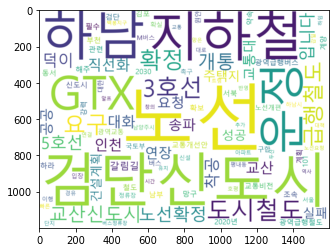

In [70]:

# count = Counter(texts)
count = Counter(texts_1d)
tags = {}
for n, c in count.most_common(100):
    tags[n] = c

wc = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
               width=800, height=600, scale=2.0, max_font_size=200, background_color="#ffffff")
#plt.rc('font', family='Nanum Gothic')

gen = wc.generate_from_frequencies(tags)
plt.figure()
plt.imshow(gen, interpolation='bilinear')
plt.show()

# wc.to_file('./png/신문고_2019_HK토큰.png')

# wc.to_file('./png/신문고_2020_HK토큰.png')

#plt.close()

# 4.0 Networkx__연관성분석

In [159]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import networkx as nx

#
## 여기서 쓰인 dataset 이 끝까지 쓰임!!
#

In [76]:

dataset=[]
for i in dfsin['token']:
    dataset.append(i)
dataset

[['마을버스', '노선'],
 ['지하철', '3호선', '대화', '덕이', '운정', '운정', '직선화', '노선', '착공', '개통'],
 ['지하철', '3호선', '대화', '덕이', '운정', '운정', '직선화', '노선', '착공', '개통'],
 ['지하철', '3호선', '대화', '덕이', '운정', '운정', '직선화', '노선', '착공', '개통'],
 ['건설', '표준', '노선', '측량', '노선', '선정', '노선', '선점', '정의'],
 ['지하철', '3호선', '대화', '덕이', '운정', '운정', '직선화', '노선', '착공', '개통'],
 ['검단신도시', '5호선', '연장', '노선확정', '촉구'],
 ['국가',
  '철도망',
  '계획',
  '반영',
  '지하철',
  '3호선',
  '운정신도시',
  '직선화',
  '노선',
  '신속',
  '착공',
  '개통',
  '추진',
  '하라'],
 ['관저동', '버스노선', '개편', '배차', '증가', '부탁'],
 ['의정부', '강변역', '까지', '운행', '중인', '의정부', '노선', '단축', '강력', '대합'],
 ['영종', '국제', '버스노선', '운행', '시간', '점검', '요청'],
 ['동탄', '신도시', '공항버스', '신규', '노선요청'],
 ['고촌읍', '신곡리', '캐슬', '앤파', '밀리', '단지', '개화역', '직통', '방향', '버스노선', '신설', '요청'],
 ['52', '버스노선', '변경', '검토'],
 ['전진', '확장', '구간', '전주', '방향', '노선', '표지판', '설치', '해주'],
 ['경기도',
  '준공',
  '영제',
  '노선',
  '사업',
  '선정',
  '동백',
  '지구',
  '잠실',
  '광역버스',
  '노선',
  '관련',
  '민원',
  '입니다'],
 ['공항철도', '도시철도', '노선요청', 

In [97]:
from apyori import apriori
# # Original 코드
# from apyori import apriori
# 연관 분석을 수행합니다.
# results = list(apriori(dataset,
#     min_support=0.06,
#     min_confidence=0.05,
#     min_lift=1.0,
#     max_length=2))
# print(results)

# # 연관 분석을 수행합니다.
results = list(apriori(dataset,
    min_support=0.10,
    min_confidence=0.03,
    min_lift=0.25,
    max_length=2))
print(results)


[RelationRecord(items=frozenset({'3호선'}), support=0.17718661829907295, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'3호선'}), confidence=0.17718661829907295, lift=1.0)]), RelationRecord(items=frozenset({'5호선'}), support=0.1192744860943168, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'5호선'}), confidence=0.1192744860943168, lift=1.0)]), RelationRecord(items=frozenset({'GTX'}), support=0.21654171704957678, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'GTX'}), confidence=0.21654171704957678, lift=1.0)]), RelationRecord(items=frozenset({'개통'}), support=0.12611043933897623, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'개통'}), confidence=0.12611043933897623, lift=1.0)]), RelationRecord(items=frozenset({'검단신도시'}), support=0.33760580411124547, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'검단신도시'}), confidence=0.3

In [105]:
from collections import Counter
# 데이터 프레임 형태로 정리합니다.
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns=columns)

### Apriori 알고리즘을, Dataframe으로 변환
# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

print(network_df)

#### Node 사이즈를 만들어주기위한 부분
dataset1d=[]

for i in dataset:
    dataset1d.extend(i)

count = Counter(dataset1d)

node_df = pd.DataFrame(count.items(), columns=['node', 'nodesize'])
#원본
# node_df = node_df[node_df['nodesize'] >= 5] # 시각화의 편의를 위해 ‘nodesize’ 5 이하는 제거합니다.
# 중복ON,전국,통합년도
node_df = node_df[node_df['nodesize'] >= 1700] # 시각화의 편의를 위해 ‘nodesize’ 5 이하는 제거합니다.

print(node_df.head())

   source target   support
0     3호선     개통  0.107166
1     3호선     노선  0.108698
2      대화    3호선  0.107279
3     3호선     덕이  0.108440
4     3호선     운정  0.108408
5     3호선    지하철  0.127755
6     직선화    3호선  0.107328
7      착공    3호선  0.107295
8     5호선  검단신도시  0.118726
9     GTX  검단신도시  0.209464
10    GTX   급행철도  0.133785
11    GTX     노선  0.180782
12    GTX     확정  0.140605
13     노선     개통  0.107215
14     대화     개통  0.107054
15     개통     덕이  0.107054
16     개통     운정  0.107021
17     개통    지하철  0.125095
18    직선화     개통  0.107102
19     착공     개통  0.107102
20   급행철도  검단신도시  0.133785
21     노선  검단신도시  0.197985
22   노선확정  검단신도시  0.122112
23     확정  검단신도시  0.158678
24   급행철도     노선  0.133849
25   급행철도     확정  0.128174
26     대화     노선  0.107263
27     노선     덕이  0.108424
28     요구     노선  0.153116
29     노선     운정  0.108392
30     노선    지하철  0.212011
31    직선화     노선  0.107328
32     착공     노선  0.107360
33     확정     노선  0.156421
34     대화     덕이  0.107279
35     대화     운정  0.107247
3

In [106]:
# from collections import Counter
# dataset1d=[]
# for i in dataset:
#     dataset1d.extend(i)

# count = Counter(dataset1d)

# node_df = pd.DataFrame(count.items(), columns=['node', 'nodesize'])
# node_df = node_df[node_df['nodesize'] >= 5]  # 시각화의 편의를 위해 ‘nodesize’ 5 이하는 제거합니다.
# node_df.head()


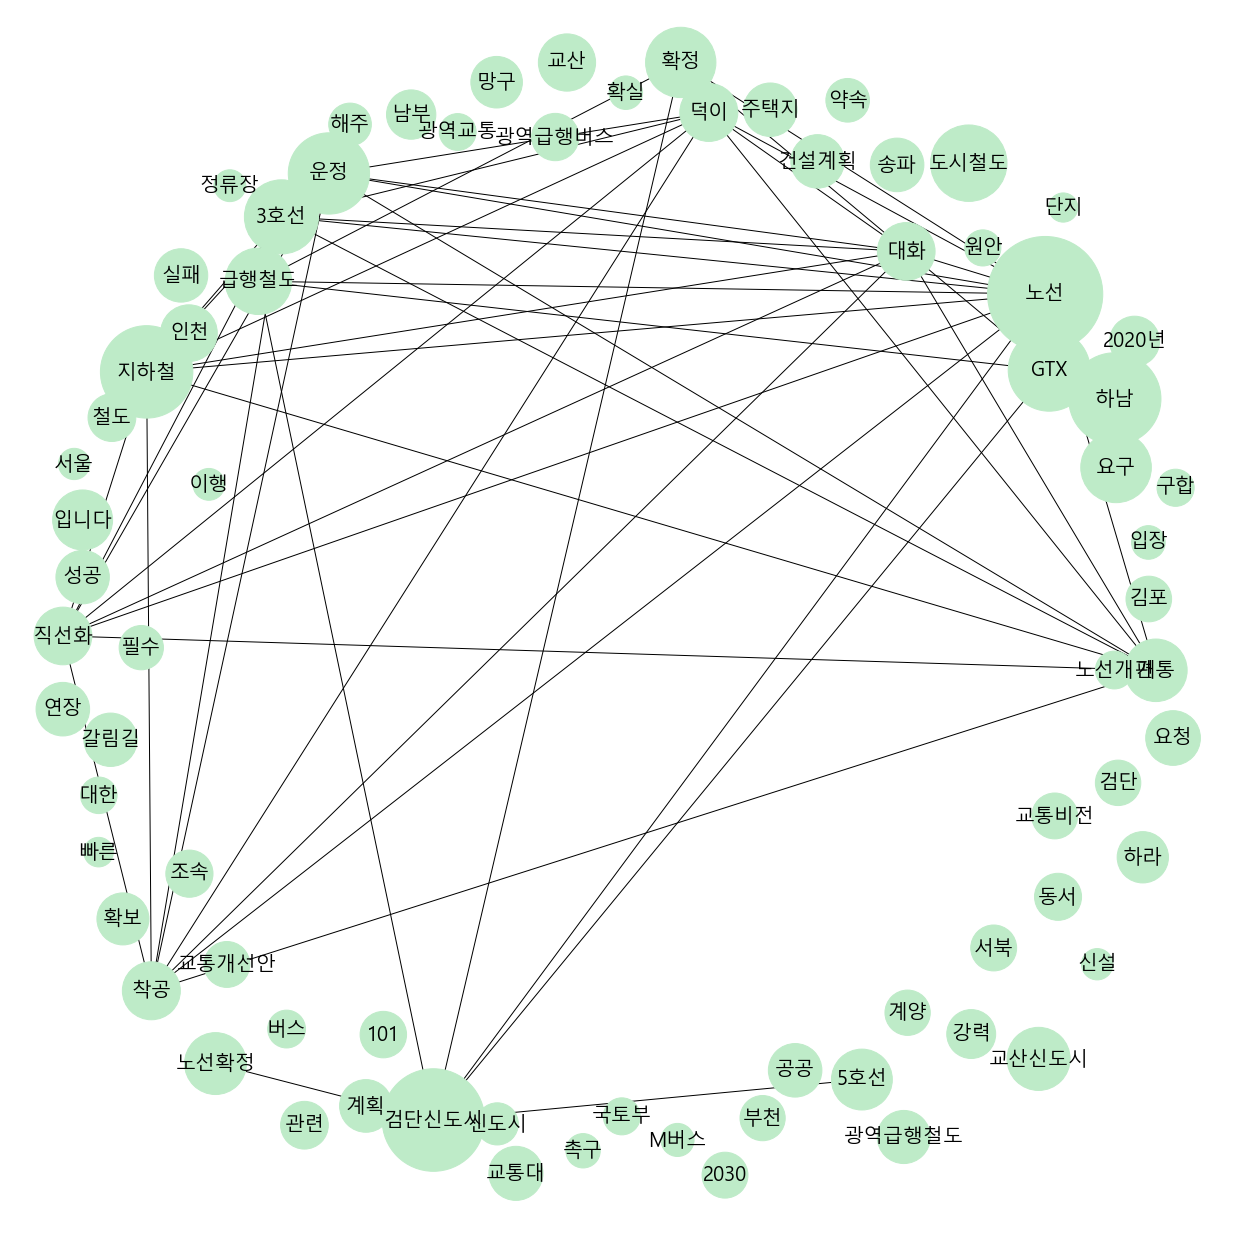

In [107]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# import numpy as np

plt.figure(figsize=(17,17))

# networkx 그래프 객체를 생성합니다.
G = nx.Graph()

# pr=nx.pageranke(G)

# node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 ‘노드’역할을 하는 원을 생성합니다.
for index, row in node_df.iterrows():
    G.add_node(row['node'], nodesize=row['nodesize'])

# network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘관계’역할을 하는 선을 생성합니다.
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

# 그래프 디자인과 관련된 파라미터를 설정합니다. 
# # original
# pos = nx.spring_layout(G, k=0.6, iterations=50)
# sizes = [G.nodes[node]['nodesize']*30 for node in G]
# #
# #원형
# pos = nx.spring_layout(G, k=1.7, iterations=50)#2019

pos = nx.spring_layout(G, k=2.66 , iterations=40)#2020
##kameda 써보기
# pos = nx.kamada_kawai_layout(G)
# #
# pos=nx.planar_layout(G)
# pos=nx.random_layout(G)
ncolor2020='#BEEBC8'
ncolor2019='#C9D7F5'
# sizes = [G.nodes[node]['nodesize']*25 for node in G] #2020
sizes = [G.nodes[node]['nodesize']*0.5 for node in G] #2019

nx.draw(G, pos=pos, node_size=sizes, node_color=ncolor2020)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=20)

# kamada_kawai 써보기!
# nx.kamada_kawai_layout(G)

# 그래프를 출력합니다.
ax = plt.gca()
plt.show()


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'c:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

## 4.1 네트워크 분석된 것의 키워드에 대한 연관성 추출

In [110]:
def mkNetworkWeight(network,keyword):
    forkey=pd.DataFrame(network[keyword].items(),columns=['keyword','Weight'])#.sort_values(by=['Weight'])
    forkey['Weight']=forkey['keyword'].apply(lambda x: network[keyword][x]['weight'])
    return forkey.sort_values(by=['Weight'],ascending=False)


# 노선,차량,정류장,운전기사 + 수단들
mkNetworkWeight(G,'검단신도시')

,keyword,Weight
1,GTX,0.209464
3,노선,0.197985
5,확정,0.158678
2,급행철도,0.133785
4,노선확정,0.122112
0,5호선,0.118726


In [132]:
G['노선']

C:\Users\hj\anaconda3\envs\textMining_ipython upgrade\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AtlasView({'3호선': {'weight': 0.1086981056025796}, 'GTX': {'weight': 0.1807819427650141}, '개통': {'weight': 0.10721483272873841}, '검단신도시': {'weight': 0.19798468359532448}, '급행철도': {'weight': 0.13384925433293027}, '대화': {'weight': 0.10726320032245062}, '덕이': {'weight': 0.10842402257154374}, '요구': {'weight': 0.15311567916162838}, '운정': {'weight': 0.10839177750906892}, '지하철': {'weight': 0.21201128577186618}, '직선화': {'weight': 0.10732769044740025}, '착공': {'weight': 0.10735993550987505}, '확정': {'weight': 0.15642079806529624}})

# 6.0.1 LDA 구축
#### Mallet LDA vs Gensim LDA -> 정확한 기준이 없이, 둘 중 더 좋은 토픽을 제공하는것을 사용하면됨

In [ ]:

# data_word=[]
# for i in ['hktoken']:
#     data_word.append(i)
# data_word

## 6.1 Mallet__LDA

In [111]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import gensim

id2word=corpora.Dictionary(dataset)           ##  Dictionary 로 쓰이는 부분 (DF_DICT)
id2word.filter_extremes(no_below = 10)        #   20회 이하로 등장한 단어는 삭제
texts = dataset                               ##  Texts로 쓰이는 부분  (tokenized_data)

corpus=[id2word.doc2bow(text) for text in texts] ## corpus로 쓰이는 부분 (DF_CORPUS)
mallet_path = '/Mallet/bin/mallet' 

In [112]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [166]:
from tqdm import tqdm 
import re 
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pickle 
import pyLDAvis.gensim 
from gensim.models.coherencemodel import CoherenceModel 

#### Mallet
def compute_coherence_values_Mallet(dictionary, corpus, texts, limit, start=4, step=2):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
#         print(f'{num_topics} 번째 토픽 검사중')
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

#### Gensim LDA
def compute_coherence_values(dictionary,corpus,texts,limit,start=5,step=2):
    coherence_values=[]
    model_list=[]
    for num_topics in tqdm(range(start,limit,step)):
#         print(f'{num_topics} 번째 토픽 검사중')
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def find_optimal_number_of_topics(ismallet, dictionary, corpus, texts, start=5, limit=21, step=2): 
    #토픽의 개수를 2~40개사이로 6step에 걸쳐서 나누어 진행
    
    if ismallet==0:# 일반 Gensim LDA 
        model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step) 
    else:
        model_list, coherence_values = compute_coherence_values_Mallet(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step) 
    
    x = range(start, limit, step) 
    topic_num = 0
    count = 0
    max_coherence = 0
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv,5))
        coherence = cv
        if coherence >= max_coherence:
            max_coherence = coherence
            topic_num = m
            model_list_num = count   
        count = count+1
    optimal_model = model_list[model_list_num]
    model_topics = optimal_model.show_topics(formatted=False)
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.show()
    return model_list, optimal_model

# # Can take a long time to run.
# model_list, coherence_values = tqdm(compute_coherence_values(dictionary=id2word, 
#                                                         corpus=corpus, texts=texts, start=4, limit=21, step=2))

# limit=21; start=4; step=2;
# x = range(start, limit, step)
# topic_num = 0
# count = 0
# max_coherence = 0
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", cv)
#     coherence = cv
#     if coherence >= max_coherence:
#         max_coherence = coherence
#         topic_num = m
#         model_list_num = count   
#     count = count+1

        
# # Select the model and print the topics
# optimal_model = model_list[model_list_num]
# model_topics = optimal_model.show_topics(formatted=False)
# #print(optimal_model.print_topics(num_words=10))

100%|██████████| 9/9 [08:41<00:00, 57.98s/it]

Num Topics = 4  has Coherence Value of 0.51224
Num Topics = 6  has Coherence Value of 0.45297
Num Topics = 8  has Coherence Value of 0.46832
Num Topics = 10  has Coherence Value of 0.43918
Num Topics = 12  has Coherence Value of 0.48604
Num Topics = 14  has Coherence Value of 0.4119
Num Topics = 16  has Coherence Value of 0.38473
Num Topics = 18  has Coherence Value of 0.41181
Num Topics = 20  has Coherence Value of 0.41904


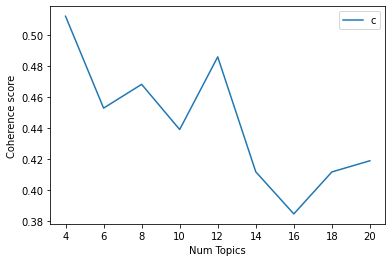

In [167]:
# gensim_model_list, gensim_optimal_model = find_optimal_number_of_topics(0,id2word, corpus, texts, start=5, limit=21, step=2)
mallet_model_list, mallet_optimal_model = find_optimal_number_of_topics(1,id2word, corpus, texts, start=5, limit=21, step=2)

100%|██████████| 8/8 [01:17<00:00,  9.67s/it]

Num Topics = 5  has Coherence Value of 0.43904
Num Topics = 7  has Coherence Value of 0.4949
Num Topics = 9  has Coherence Value of 0.50632
Num Topics = 11  has Coherence Value of 0.47498
Num Topics = 13  has Coherence Value of 0.47749
Num Topics = 15  has Coherence Value of 0.45999
Num Topics = 17  has Coherence Value of 0.41616
Num Topics = 19  has Coherence Value of 0.42483


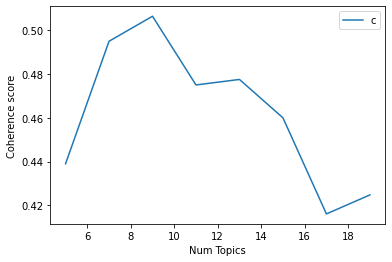

In [184]:
gensim_model_list, gensim_optimal_model = find_optimal_number_of_topics(0,id2word, corpus, texts, start=5, limit=21, step=2)

C:\Users\hj\anaconda3\envs\textMining_ipython upgrade\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4 번째 토픽 검사중
6 번째 토픽 검사중
8 번째 토픽 검사중
10 번째 토픽 검사중
12 번째 토픽 검사중
14 번째 토픽 검사중
16 번째 토픽 검사중
18 번째 토픽 검사중
20 번째 토픽 검사중
Num Topics = 4  has Coherence Value of 0.48854495722566127
Num Topics = 6  has Coherence Value of 0.47039203608447816
Num Topics = 8  has Coherence Value of 0.42609563847953913
Num Topics = 10  has Coherence Value of 0.4810943978869882
Num Topics = 12  has Coherence Value of 0.47401101869457185
Num Topics = 14  has Coherence Value of 0.41807033482190237
Num Topics = 16  has Coherence Value of 0.46380112384778766
Num Topics = 18  has Coherence Value of 0.44987693597854694
Num Topics = 20  has Coherence Value of 0.4724840553374744


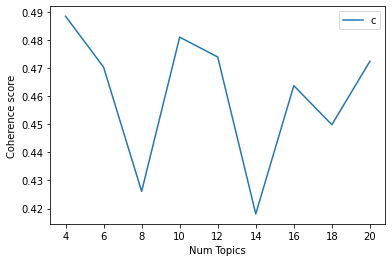

In [135]:
# def find_optimal_number_of_topics(ismallet, dictionary, corpus, texts, start=4, limit=21, step=2): 
#     #토픽의 개수를 2~40개사이로 6step에 걸쳐서 나누어 진행
    
#     if ismallet==0:# 일반 Gensim LDA 
#         model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step) 
#     else:
#         model_list, coherence_values = compute_coherence_values_Mallet(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step) 
    
#     x = range(start, limit, step) 
#     topic_num = 0
#     count = 0
#     max_coherence = 0
#     for m, cv in zip(x, coherence_values):
#         print("Num Topics =", m, " has Coherence Value of", round(cv,5))
#         coherence = cv
#         if coherence >= max_coherence:
#             max_coherence = coherence
#             topic_num = m
#             model_list_num = count   
#         count = count+1
#     optimal_model = model_list[model_list_num]
#     model_topics = optimal_model.show_topics(formatted=False)
#     plt.plot(x, coherence_values) 
#     plt.xlabel("Num Topics") 
#     plt.ylabel("Coherence score") 
#     plt.legend(("coherence_values"), loc='best') 
#     plt.show()
#     return model_list, optimal_model

# model_list, optimal_model = find_optimal_number_of_topics(1,id2word, corpus, texts, start=4, limit=21, step=2)

## 6.3 LDA의 토픽 모델링 후 시각화 및 Dataframe으로 뽑아내기

## 6.3.1 Mallet의 시각화

In [173]:
import numpy as np
from gensim.models import LdaModel

def mallet_to_lda(optimal_model):
    model_gensim = LdaModel(
        id2word=optimal_model.id2word, num_topics=optimal_model.num_topics,
        alpha=optimal_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = optimal_model.wordtopics
    return model_gensim

model = mallet_to_lda(mallet_model_list[5])

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
pyLDAvis.save_html(vis, './lda/신문고_LDA_20xx_topic_12.html') 
vis


C:\Users\hj\anaconda3\envs\textMining_ipython upgrade\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\hj\anaconda3\envs\textMining_ipython upgrade\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\hj\anaconda3\envs\textMining_ipython upgrade\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.189178 -0.192672       1        1  7.190822
4     -0.092631 -0.025303       2        1  7.174311
8     -0.107948 -0.062046       3        1  7.159426
11     0.117444  0.292072       4        1  7.158541
12    -0.167382 -0.055695       5        1  7.157588
2      0.348724 -0.062750       6        1  7.152612
9      0.120214  0.305915       7        1  7.150561
5     -0.213138  0.155849       8        1  7.129062
7      0.345917  0.006283       9        1  7.128991
13    -0.097822 -0.203873      10        1  7.128665
3     -0.159434  0.030325      11        1  7.128423
0     -0.112011  0.070312      12        1  7.125349
1      0.035555 -0.250615      13        1  7.118158
10    -0.206665 -0.007802      14        1  7.097491, topic_info=      Term     Freq         Total Category  logprob  loglift
0       노선  33829.0  33829.000000  Default     30.0     30.0
13   검단신도시  25544.0  25544.000000  Default     29.0     29.0
6       운정  10000.0  10000.000000  Default     28.0     28.0
76     GTX  15824.0  15824.000000  Default     27.0     27.0
7      지하철  20546.0  20546.000000  Default     26.0     26.0
..     ...      ...           ...      ...      ...      ...
310     거리      0.0     16.907622  Topic14     -inf     -inf
311     결과      0.0     24.797846  Topic14     -inf     -inf
307     업무      0.0     18.884329  Topic14     -inf     -inf
934    부평구      0.0    320.117649  Topic14     -inf     -inf
304    그대로      0.0     12.264532  Topic14     -inf     -inf

[626 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
249       9  0.698135   101
249      10  0.301860   101
615       4  0.943428   102
615      10  0.089850   102
459       2  0.079563   103
...     ...       ...   ...
153       7  1.000841    확충
219       7  0.999645    환승
422       4  0.904328   활성화
422       8  0.064595   활성화
839       9  0.969215  횡단보도

[539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 9, 12, 13, 3, 10, 6, 8, 14, 4, 1, 2, 11])

## 6.3.2 Gensim LDA 의 시각화

In [186]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(gensim_optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, './lda/신문고_LDA_20xx_topic_9.html') 
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.224686 -0.205250       1        1  18.433360
5      0.196654  0.027532       2        1  16.582774
7     -0.135651  0.297847       3        1  13.755725
1     -0.285842 -0.136977       4        1  12.389523
2     -0.183637  0.242618       5        1  11.017148
8      0.194380 -0.045910       6        1   7.487324
4      0.048329 -0.250258       7        1   7.369370
3      0.216260  0.071975       8        1   6.513970
0      0.174192 -0.001577       9        1   6.450807, topic_info=     Term          Freq         Total Category  logprob  loglift
2     3호선  17514.000000  17514.000000  Default  30.0000  30.0000
335    하남  19417.000000  19417.000000  Default  29.0000  29.0000
72   도시철도  11975.000000  11975.000000  Default  28.0000  28.0000
12    5호선   8078.000000   8078.000000  Default  27.0000  27.0000
7     지하철  14579.000000  14579.000000  Default  26.0000  26.0000
..    ...           ...           ...      ...      ...      ...
99     버스    854.849769    897.510610   Topic9  -3.7589   2.6923
28     부탁    357.924134    360.213388   Topic9  -4.6295   2.7346
512    해결    399.370303    455.975868   Topic9  -4.5199   2.6084
206    시티    352.732796    358.062232   Topic9  -4.6441   2.7260
40     요청    691.215209   4671.933543   Topic9  -3.9713   0.8301

[372 rows x 6 columns], token_table=      Topic      Freq Term
term                      
179       5  0.749526   10
179       7  0.187382   10
249       1  0.990333  101
249       4  0.007934  101
249       5  0.000361  101
...     ...       ...  ...
153       7  0.005960   확충
850       7  0.002734   회사
850       9  0.995189   회사
193       4  0.783344   회차
193       7  0.156669   회차

[744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 2, 3, 9, 5, 4, 1])

### https://projector.tensorflow.org/ 에 시각화하기!

In [ ]:
# https://projector.tensorflow.org/ 에 시각화하기!
filename="신문고_LDA_20xx"
model.wv.save_word2vec_format(f'./lda/{filename}') # 모델 저장
#!python -m gensim.scripts.word2vec2tensor --input f'./lda/{filename}' --output f'./lda/{filename}'
!python -m gensim.scripts.word2vec2tensor --input ./lda/신문고_LDA_20xx --output ./lda/신문고_LDA_20xx

### gensim_optimal_model 구분 잘하기 

In [187]:
#시작 전 세팅
optimal_model = gensim_optimal_model

## texts 에 원본 텍스트가 들어가야한다
texts = dfsin['text']


# dataset=dfsin['text']
# corpus=corpus
# texts=dateset

In [194]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     sent_topics_df = pd.concat([sent_topics_df,texts], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

62025it [02:16, 453.96it/s]

<class 'pandas.core.frame.DataFrame'>


In [195]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,8.0,0.3834,"대한, 사업, 원안, 국가, 요청, 트램, 내부, 경제, 하남시, 관련",2번 마을버스 노선
1,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
2,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
3,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
4,1.0,0.5140,"확보, 요구, 급행철도, 노선, GTX, 검단신도시, 강력, 확정, 서북, 교통개선안",건설표준품셈 노선측량 중 노선선정과 노선선점 정의
...,...,...,...,...
62020,0.0,0.1111,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",대전역 서광장 택시전용차로
62021,0.0,0.5556,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",1가구 4주택시 취득세 4% 문의드립니다.
62022,0.0,0.4964,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일","울산 남구 롯데시티호텔,신라스테이 앞 택시 승강장 만들어주셔요"
62023,3.0,0.2781,"국토부, 해주, 확실, 강남, 위해, 이용, 노력, 대로, 불편, 약속",택시에 휴대폰을 두고 내렸는데 과도한 보상금을 요구 (광주)


In [196]:
# Format
df_dominant_topic = df_topic_sents_keywords#
df_dominant_topic.columns = [
    'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,8.0,0.3834,"대한, 사업, 원안, 국가, 요청, 트램, 내부, 경제, 하남시, 관련",2번 마을버스 노선
1,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
2,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
3,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
4,1.0,0.5140,"확보, 요구, 급행철도, 노선, GTX, 검단신도시, 강력, 확정, 서북, 교통개선안",건설표준품셈 노선측량 중 노선선정과 노선선점 정의
...,...,...,...,...
62020,0.0,0.1111,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",대전역 서광장 택시전용차로
62021,0.0,0.5556,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",1가구 4주택시 취득세 4% 문의드립니다.
62022,0.0,0.4964,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일","울산 남구 롯데시티호텔,신라스테이 앞 택시 승강장 만들어주셔요"
62023,3.0,0.2781,"국토부, 해주, 확실, 강남, 위해, 이용, 노력, 대로, 불편, 약속",택시에 휴대폰을 두고 내렸는데 과도한 보상금을 요구 (광주)


In [197]:
df_topic_sents_keywords

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,8.0,0.3834,"대한, 사업, 원안, 국가, 요청, 트램, 내부, 경제, 하남시, 관련",2번 마을버스 노선
1,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
2,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
3,7.0,0.9192,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정1-운정2의 직선화 노선으로 조속히 착공하여 개통시켜 ...
4,1.0,0.5140,"확보, 요구, 급행철도, 노선, GTX, 검단신도시, 강력, 확정, 서북, 교통개선안",건설표준품셈 노선측량 중 노선선정과 노선선점 정의
...,...,...,...,...
62020,0.0,0.1111,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",대전역 서광장 택시전용차로
62021,0.0,0.5556,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",1가구 4주택시 취득세 4% 문의드립니다.
62022,0.0,0.4964,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일","울산 남구 롯데시티호텔,신라스테이 앞 택시 승강장 만들어주셔요"
62023,3.0,0.2781,"국토부, 해주, 확실, 강남, 위해, 이용, 노력, 대로, 불편, 약속",택시에 휴대폰을 두고 내렸는데 과도한 보상금을 요구 (광주)


In [198]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

lda_inform = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
lda_inform.columns=["Topic_Num", "Topic_Perc_Contrib", "Keywords", "Text","Num_Documents", "Perc_Documents"]
lda_inform = lda_inform[["Topic_Num","Keywords","Num_Documents","Perc_Documents"]]
lda_inform
# #lda_inform.Topic_Num = lda_inform.Topic_Num.astype(int)
# lda_inform['Topic_Num'] =lda_inform['Topic_Num'] +1
# lda_inform.Topic_Num = lda_inform.Topic_Num.astype(str)
# lda_inform['Topic_Num'] =lda_inform['Topic_Num'].str.split('.').str[0]
# df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'] +1
# df_topic_tweet.Dominant_Topic = df_topic_tweet.Dominant_Topic.astype(str)
# df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'].str.split('.').str[0]
 

,Topic_Num,Keywords,Num_Documents,Perc_Documents
0.0,0.0,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일",6395,0.1031
1.0,1.0,"확보, 요구, 급행철도, 노선, GTX, 검단신도시, 강력, 확정, 서북, 교통개선안",6235,0.1005
2.0,2.0,"도시철도, 지하철, 인천, 연장, 계획, 망구, 노선, 요구, 서울, 반영",7165,0.1155
3.0,3.0,"국토부, 해주, 확실, 강남, 위해, 이용, 노력, 대로, 불편, 약속",6059,0.0977
4.0,4.0,"5호선, 구역, 자유, 검단신도시, 시행, 촉구, 노선확정, 요청, 광역급행버스, 단지",6512,0.1050
5.0,5.0,"교산신도시, 철도, 교산, 교통대, 송파, 주택지, 건설계획, 공공, 성공, 갈림길",8470,0.1366
6.0,6.0,"하남, 광역급행철도, 남부, 입니다, 검단신도시, GTX, 조속, 급행철도, 노선, 동서",7294,0.1176
7.0,7.0,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",7470,0.1204
8.0,8.0,"대한, 사업, 원안, 국가, 요청, 트램, 내부, 경제, 하남시, 관련",6425,0.1036


In [199]:
sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9111,"택시, 이행, 개인, 택시기사, 국토교통부, 버스, 문의, 감일, 변경, 시일","버스정류장 명칭 정정 요청 [법화터널 입구] -> [법화터널 입구, 물푸레마을]"
1,1.0,0.9316,"확보, 요구, 급행철도, 노선, GTX, 검단신도시, 강력, 확정, 서북, 교통개선안",광역교통노선(GTX-D)의 검단신도시 연결을 촉구합니다광역교통노선(GTX-D)의 검...
2,2.0,0.8730,"도시철도, 지하철, 인천, 연장, 계획, 망구, 노선, 요구, 서울, 반영",인천지하철 도시철도망구축계획 요구
3,3.0,0.9012,"국토부, 해주, 확실, 강남, 위해, 이용, 노력, 대로, 불편, 약속",M6439 광역버스 인하로 노선 변경 및 서창1지구 경유 불가
4,4.0,0.9192,"5호선, 구역, 자유, 검단신도시, 시행, 촉구, 노선확정, 요청, 광역급행버스, 단지",검단신도시 5호선 2020년 노선확정 촉구!검단신도시 5호선 2020년 노선확정...
5,5.0,0.8262,"교산신도시, 철도, 교산, 교통대, 송파, 주택지, 건설계획, 공공, 성공, 갈림길",하남교산 공공주택지구 교통대책(송파~하남간 도시철도 건설계획)은 교산신도시의 성공과...
6,6.0,0.9477,"하남, 광역급행철도, 남부, 입니다, 검단신도시, GTX, 조속, 급행철도, 노선, 동서",검단신도시 동서축 GTX-D(광역급행철도)노선(김포-검단101-계양.부천-남부급행철...
7,7.0,0.9259,"3호선, 운정, 입장, 지하철, 개통, 노선, 착공, 덕이, 직선화, 대화",지하철 3호선 대화-덕이-운정행복센터의 직선화 노선으로 조속히 착공하여 개통시켜 주세요!
8,8.0,0.9259,"대한, 사업, 원안, 국가, 요청, 트램, 내부, 경제, 하남시, 관련",동탄2신도시 트램 여울공원역(307정거장) 원안노선 추진요청
